In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [57]:
N = 1000
series = np.sin(0.1 * np.arange(N)) + 0.1 *np.random.rand(N)
len(series)

1000

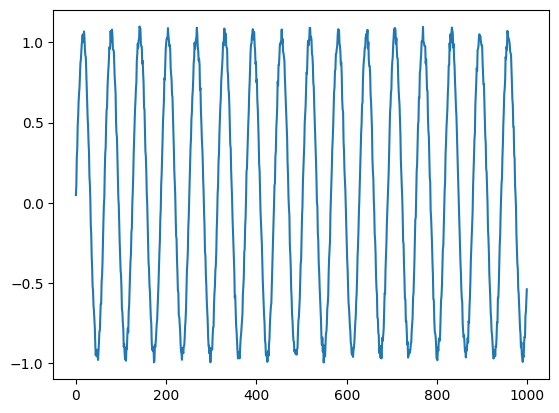

In [58]:
plt.plot(series)
plt.show()

In [59]:
#Build the data

T = 10
X = []
Y = []

for i in range(len(series)-T):
  x = series[i:i+10]
  X.append(x)
  y = series[i+10]
  Y.append(y)

print(len(X),len(Y))

990 990


In [60]:
X = np.array(X)
Y = np.array(Y)
print(X.shape,Y.shape)

(990, 10) (990,)


In [61]:
X = X.reshape(-1,T,1)
Y = Y.reshape(-1,1)
Y.shape,X.shape

((990, 1), (990, 10, 1))

In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [63]:
#Split the data into train and test

X_train = torch.from_numpy(X[:N//2].astype("float32")).to(device)
X_test = torch.from_numpy(X[N//2:].astype("float32")).to(device)
Y_train = torch.from_numpy(Y[:N//2].astype("float32")).to(device)
Y_test = torch.from_numpy(Y[N//2:].astype("float32")).to(device)

In [64]:
#build the model

class MyRNN(nn.Module):
  def __init__(self,inputs,hidden,outputs,layers):
    super(MyRNN,self).__init__()

    self.D = inputs
    self.M = hidden
    self.K = outputs
    self.L = layers


    self.rnn = nn.RNN(input_size = self.D, hidden_size = self.M,num_layers = self.L, nonlinearity = 'relu',batch_first = True)


    self.fc = nn.Linear(self.M,self.K)

  def forward(self,x):

    h_0 = torch.zeros(self.L,x.size(0),self.M).to(device)
    out, _ = self.rnn(x,h_0)
    out = out[:,-1,:]

    out = self.fc(out)

    return out


In [65]:
model = MyRNN(1,15,1,1)
model.to(device)

MyRNN(
  (rnn): RNN(1, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [66]:
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

(torch.Size([500, 10, 1]),
 torch.Size([500, 1]),
 torch.Size([490, 10, 1]),
 torch.Size([490, 1]))

In [67]:
#test
A = [1,2,3,4]
l = len(A)
A[-l//2:]

[3, 4]

In [68]:
#optimization

criterion  = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)

In [69]:
#training

epochs = 500

train_loss = np.zeros(epochs)



for i in range(epochs):

  optimizer.zero_grad()

  outputs = model(X_train)

  loss_train = criterion(outputs,Y_train)

  loss_train.backward()

  optimizer.step()

  train_loss[i] = loss_train.item()

  print(f"epoch -- {i+1}/{epochs}, training loss -- {loss_train.item()} ")





epoch -- 1/500, training loss -- 0.5355054140090942 
epoch -- 2/500, training loss -- 0.4886651337146759 
epoch -- 3/500, training loss -- 0.4426611661911011 
epoch -- 4/500, training loss -- 0.39666974544525146 
epoch -- 5/500, training loss -- 0.35390427708625793 
epoch -- 6/500, training loss -- 0.3109899163246155 
epoch -- 7/500, training loss -- 0.2687225341796875 
epoch -- 8/500, training loss -- 0.22905460000038147 
epoch -- 9/500, training loss -- 0.19222867488861084 
epoch -- 10/500, training loss -- 0.15991148352622986 
epoch -- 11/500, training loss -- 0.13095460832118988 
epoch -- 12/500, training loss -- 0.10375693440437317 
epoch -- 13/500, training loss -- 0.08192402869462967 
epoch -- 14/500, training loss -- 0.06909924745559692 
epoch -- 15/500, training loss -- 0.06073341146111488 
epoch -- 16/500, training loss -- 0.05342618003487587 
epoch -- 17/500, training loss -- 0.04889284819364548 
epoch -- 18/500, training loss -- 0.04659844562411308 
epoch -- 19/500, trainin

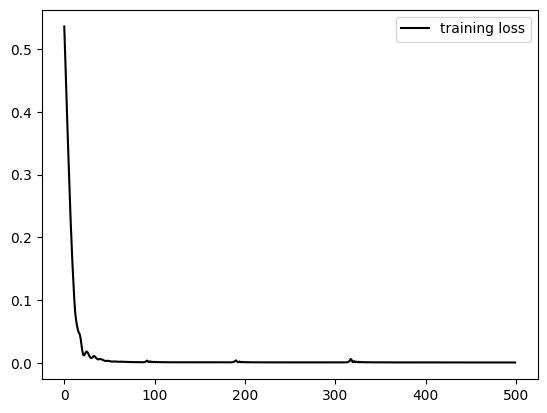

In [70]:
plt.plot(train_loss,label = "training loss", c= "black")
plt.legend()
plt.show()

In [71]:
#prediction -- correct forecasting

test_predictions = []

last_x = X_test[0].view(T)

while len(test_predictions) < len(Y_test):
  input  = last_x.view(1,T,1)


  output  = model(input)

  test_predictions.append(output[0,0].item())

  last_x = torch.cat((last_x[1:],output[0]))




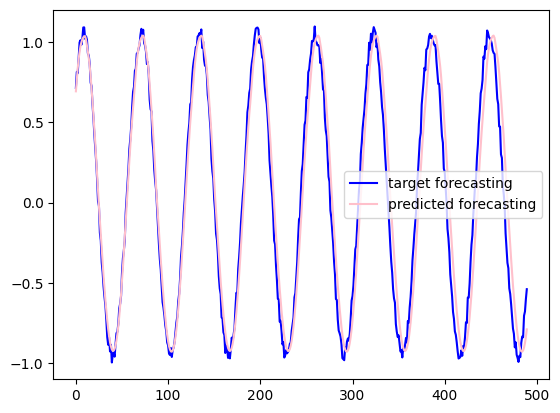

In [72]:

plt.plot(Y_test.cpu().numpy(),label = "target forecasting", c = "blue")
plt.plot(test_predictions,label = "predicted forecasting",c="pink")
plt.legend()
plt.show()

In [73]:
# Wrong forecasting

test_predictions = []

i = 0

while len(test_predictions) < len(Y_test):

  input = X_test[i].view(1,T,1)

  output = model(input)[0,0].item()

  test_predictions.append(output)

  i+=1





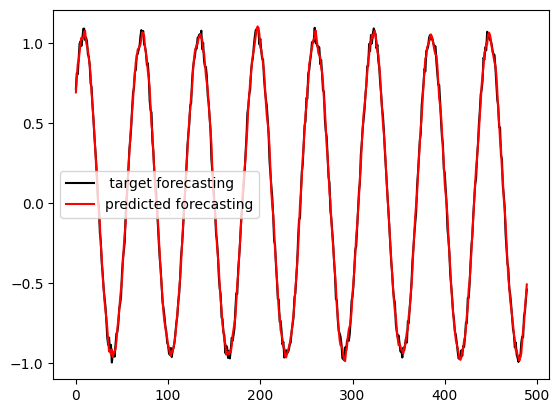

In [74]:

plt.plot(Y_test.cpu().numpy(),label = " target forecasting", c = "black")
plt.plot(test_predictions,label = "predicted forecasting", c = "r")
plt.legend()
plt.show()